# Small

Ideja je napraviti manji model od prethodnog i proceniti kako će se ponašati kada ima drastično manje parametara. Suština procesa će biti ista i akcenat je na menjanju arhitekture. Produbljivanje konvolucije ne dovodi do velikog povećanja parametara, ali smanjuje broj čvorova koji ulaze u gustu mrežu. Takođe, sama gusta mreža može biti smanjenja. Cilj je videti da li manji broj parametara dovodi do gubitka opštosti.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
data_dir = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/scaled"

In [4]:
def load_images_to_numpy(src_path: str) -> np.ndarray:
    res = os.listdir(src_path)
    res = map(lambda path: os.path.join(src_path, path), res)
    res = map(Image.open, res)
    res = map(np.asarray, res)
    res = np.stack([*res], axis=0)
    return res

def load_images(src_path: str):
    X_false = load_images_to_numpy(os.path.join(src_path, "NORMAL"))
    y_false = np.zeros((X_false.shape[0],), dtype=np.uint8)

    X_true = load_images_to_numpy(os.path.join(src_path, "PNEUMONIA"))
    y_true = np.ones((X_true.shape[0],), dtype=np.uint8)

    X = np.concatenate([X_false, X_true])
    y = np.concatenate([y_false, y_true])
    return (X, y)

X, y = load_images(os.path.join(data_dir, "train"))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [5]:
def make_model(shape, activation, **kwargs):
    model = Sequential()
    model.add(InputLayer(shape))
    model.add(Reshape((shape[0], shape[1], 1)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation=activation))
    model.compile(**kwargs)
    return model

In [6]:
model = make_model(
    shape=(X_train.shape[1], X_train.shape[2]),
    activation='sigmoid',
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 280, 400, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 278, 398, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 139, 199, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 137, 197, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 68, 98, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 66, 96, 64)        1

In [8]:
print(f"Procenat broja parametara u odnosu na pro[li model: {209_232/12_999_681*100:.1f}%")

Procenat broja parametara u odnosu na pro[li model: 1.6%


Poenta je videti da li slične performance kao sa prethodnim modelom mogu da se postignu sa manjim modelom. Rezultujući model nalaziće se na putanji `/content/drive/MyDrive/MasinskoUcenjeChestXRay/models/small`

In [12]:
model_path = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/models/small"
if not os.path.isdir(model_path):
        os.makedirs(model_path)
model_checkpoints_path = os.path.join(model_path, "checkpoint")
if not os.path.isdir(model_checkpoints_path):
        os.makedirs(model_checkpoints_path)

In [13]:
history = model.fit(
    X_train, y_train,
    verbose=0,
    epochs=50,
    validation_split=0.1,
    callbacks=[
        ModelCheckpoint(
          filepath=os.path.join(model_checkpoints_path, "{epoch:02d}.h5"),
          save_best_only=True,
          monitor='val_loss',
          mode='min'
        )
    ]
)

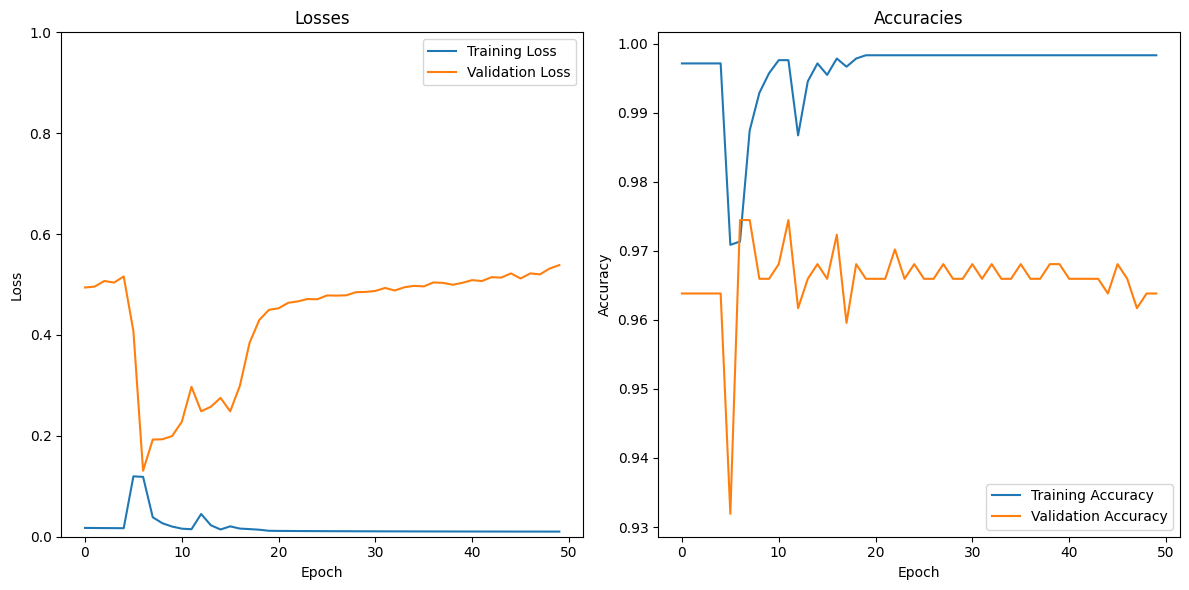

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

U epohi 7 deluje kao da je model došao do nekog smislenog saznanja, i onda počinje da se preprilagođava. Iako kriva za preciznost deluje kao da se pomera, relativno je stabilna, a loss biva sve gori i gori.

In [16]:
best_model = load_model(os.path.join(model_checkpoints_path, "07.h5"))

In [18]:
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred < 0.5, 0, 1)

17/17 [==============================] - 0s 14ms/step


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       134
           1       0.96      0.97      0.97       388

    accuracy                           0.95       522
   macro avg       0.94      0.93      0.94       522
weighted avg       0.95      0.95      0.95       522



In [21]:
pd.DataFrame(confusion_matrix(y_test, y_pred), index=["NORMAL", "PNEUMONIA"], columns=["NORMAL", "PNEUMONIA"])

,NORMAL,PNEUMONIA
NORMAL,120,14
PNEUMONIA,11,377


Model ima blago lošije performanse na predviđanje pozitivnih instanci, ali se slabost najviše vidi na predviđanju negativnih. Pad od 2% u odzivu pozitivne i 4% negativne vrednosti nije loše s obzirom da koristimo model koji ima samo 1% parametara u odnosu na prethodni.